*Note*: You need to submit the assignment to be graded, and passing the validation button's test does not grade the assignment. The validation button's functionality is exactly the same as running all cells.

*If you plan to run the assignment locally:*
You can download the assignments and run them locally, but please be aware that as much as we would like our code to be universal, computer platform differences may lead to incorrectly reported errors even on correct solutions. Therefore, we encourage you to validate your solution in Coursera whenever this may be happening. If you decide to run the assignment locally, please: 
   1. Try to download the necessary data files from your home directory one at a time,
   2. Don't update anything other than this Jupyter notebook back to Coursera's servers, and 
   3. Make sure this notebook maintains its original name after you upload it back to Coursera.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from scipy.special import logsumexp

from aml_utils import test_case_checker, perform_computation

# *Assignment Summary

**EM Topic models** The UCI Machine Learning dataset repository hosts several datasets recording word counts for documents at https://archive.ics.uci.edu/ml/datasets/Bag+of+Words. You will use the NIPS dataset. You will find (a) a table of word counts per document and (b) a vocabulary list for this dataset at the link. You must implement the multinomial mixture of topics model, lectured in class. For this problem, you should write the clustering code yourself (i.e. not use a package for clustering).
  * Cluster this to 30 topics, using a simple mixture of multinomial topic model, as lectured in class.
  * Produce a graph showing, for each topic, the probability with which the topic is selected.
  * Produce a table showing, for each topic, the 10 words with the highest probability for that topic.

# *EM for Topic model in Matrix Form

For you convenience, we bring the reading assignment file here so that you can use it.

<font color='red'> **Caution** </font> Depending on your browser, you might need to right click on this pdf document to see the display options.

In [2]:
from IPython.display import IFrame
IFrame("../EMTopicModel-lib/EMTopicModel.pdf", width=1000, height=800)

# 0. Data

## 0.1 Description

There are multiple collection of word-count datasets available at https://archive.ics.uci.edu/ml/datasets/Bag+of+Words . We will be using the NIPS collection of words in this exercise. This dataset is composed of papers presented at the Conference of Neural Information Processing Systems (formerly NIPS, which is now knows as NeurIPS).

## 0.2 Information Summary

* **Input/Output**: There are a total of 12419 words counted, and 1500 documents were surveyed. Therefore, the data can be stored in a count array with a shape of `(1500, 12419)`.

* **Missing Data**: There is no missing data.

* **Final Goal**: We want to fit an EM topic model for clustering the documents.

In [3]:
data_file = f'../EMTopicModel-lib/words/docword.nips.txt'

with open(data_file) as fh:
    for line_num, line in enumerate(fh):
        if line_num == 0:
            N = int(line) # Number of documents
        elif line_num == 1:
            d = int(line) # Number of words
            X = np.zeros((N, d))
        elif line_num == 2:
            NNZ = int(line)
        else:
            doc_id, word_id, count = tuple([int(a) for a in line.split(' ')])
            X[doc_id-1, word_id-1] = count

assert X[X>0].size == NNZ

In [4]:
with open('../EMTopicModel-lib/words/vocab.nips.txt') as fh2:
    words = [line.rstrip() for line in fh2]
    
assert len(words) == d

# 1. Implementing the EM Topic Model

# <span style="color:blue">Task 1</span>

In this task, we want to implement the E-step.

Write a function `find_logW` that calculates the $\log W_{i,j}$ matrix, and takes the following arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of documents and `d` is the number of words. Do not assume anything about `N` or `d` other than being a positive integer. This variable is equivalent to the data matrix $X$ in the review document above.
2. `log_P`: A numpy array of the shape `(t,d)` where `t` is the number of topics for clustering and `d` is the number of words. Again, do not assume anything about `t` or `d` other than being a positive integer. This variable is equivalent to the element-wise natural log of the topic probability matrix $P$ in the review document above, which we also showed by $\tilde{P}$.
3. `log_pi`: A numpy array of the shape `(t,1)` where `t` is the number of topics for clustering. This variable is equivalent to the element-wise natural log of the prior probabilities vector $\pi$ in the review document above, which we also showed by $\tilde{\pi}$.

Your model should return the numpy array `log_W` with the shape of `(N, t)` whose $i^{th}$ row and $j^{th}$ column should be
$$\log W_{i,j} = \log\bigg(\frac{\pi_j \prod_{k=1}^{d} P_{j,k}^{x_{i,k}}}{\sum_{l=1}^{t} \pi_l \prod_{k=1}^{d} P_{l,k}^{x_{i,k}}}\bigg).$$

**Important Note**: You **should** use the `logsumexp` function imported above from scipy's library to make sure that numerical stability would not be a problem.

In [50]:
def find_logW(X, log_P, log_pi):
    """
    Compute the weights W from the E step of expectation maximization.
    
        Parameters:
                X (np.array): A numpy array of the shape (N,d) where N is the number of documents and d is the number of words.
                log_P (np.array): A numpy array of the shape (t,d) where t is the number of topics for clustering and d is the number of words.
                log_pi (np.array): A numpy array of the shape (t,1) where t is the number of topics for clustering.
                
        Returns:
                log_W (np.array): A numpy array of the shape (N,t) where N is the number of documents and t is the number of topics for clustering.
    """
    N, d = X.shape
    t = log_pi.shape[0]
    
    r = np.ones((N,1)) * log_pi.T + np.dot(X,log_P.T)
    s = logsumexp(r,axis=1,keepdims=True)
    
    log_W = r - s
    
    # your code here
    #raise NotImplementedError
    
    assert log_W.shape == (N, t)
    return log_W

In [51]:
# Performing sanity checks on your implementation

some_X = 1 + (np.arange(35).reshape(7,5) ** 13) % 20
some_log_P = np.log(some_X[:3, :]/np.sum(some_X[:3, :], axis=1).reshape(-1,1))
some_log_pi = np.log(some_X[:3, 0]/np.sum(some_X[:3, 0])).reshape(-1,1)
some_log_W = find_logW(some_X, some_log_P, some_log_pi)

assert np.array_equal(some_log_W.round(2), np.array([[ -0.  ,  -9.07,  -6.1 ],
                                                     [-24.61,  -0.  , -12.27],
                                                     [-12.59,  -6.01,  -0.  ],
                                                     [-23.81,  -0.  , -29.1 ],
                                                     [ -0.  ,  -9.07,  -6.1 ],
                                                     [-24.61,  -0.  , -14.62],
                                                     [-29.96,  -0.  , -10.82]]))

# Checking against the pre-computed test database

test_results = test_case_checker(find_logW, task_id=1)
assert test_results['passed'], test_results['message']

In [ ]:
# The following are hints to make your life easier duing debugging if you failed the pre-computed tests.
#
#   When an error is raised in checking against the pre-computed test database:
#
#     0. test_results will be a python dictionary, with the bug information stored in it. Don't be afraid to look into it!
#
#     1. You can access the failed test arguments by reading test_results['test_kwargs']. test_results['test_kwargs'] will be
#        another python dictionary with its keys being the argument names and the values being the argument values.
#
#     2. test_results['correct_sol'] will contain the correct solution.
#
#     3. test_results['stu_sol'] will contain your implementation's returned solution.


# <span style="color:blue">Task 2</span>

In this task, we want to implement the first part of the M-step.

Write a function `update_logP` that does the maximization step for the $\log P_{i,j}$ matrix, and takes the following arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of documents and `d` is the number of words. Do not assume anything about `N` or `d` other than being a positive integer. This variable is equivalent to the data matrix $X$ in the review document above.
2. `log_W`: A numpy array of the shape `(N,t)` where `N` is the number of documents and `t` is the number of topics for clustering. Again, do not assume anything about `t` other than being a positive integer. This variable is equivalent to the element-wise natural log of the $W$ matrix referenced in the document above and in the textbook. We also used the notation $\tilde{W}$ for this matrix in the document above. `log_W` is the same as the output from the previous function you wrote.
3. `eps`: A very small $\epsilon$ scalar added to make sure the log operation has enough numerical stability. The document above suggests computing the matrix $E$ using the following relation
$$E_{t\times d} = [W^T]_{t\times N} \cdot X_{N\times d}. $$
However, we will make a small modification to this calculation by incorporating an insurance epsilon.
$$E_{t\times d} = [W^T]_{t\times N} \cdot X_{N\times d} + \epsilon.$$
You should implement the $E = W^T \cdot X + \epsilon$ in your code.

Your model should return the numpy array `log_P` with the shape of `(t, d)` whose $j^{th}$ row should be
$$\log \mathbf{p}_j = \log \left(\frac{\sum_{i=1}^{N} \mathbf{x}_i W_{i,j}}{\sum_{i=1}^{N} (\mathbf{x}_i^T\mathbf{1}) W_{i,j}}\right).$$
Here, $\log$ is the element-wise logarithm in the natural basis.

**Important Note**: You **should** use the `logsumexp` function imported above from scipy's library to make sure that numerical stability would not be a problem.

In [62]:
def update_logP(X, log_W, eps=1e-100):
    """
    Compute the parameters log(P) from the M step of expectation maximization.
    
        Parameters:
                X (np.array): A numpy array of the shape (N,d) where N is the number of documents and d is the number of words.
                log_W (np.array): A numpy array of the shape (N,t) where N is the number of documents and t is the number of topics for clustering.
                
        Returns:
                log_P (np.array): A numpy array of the shape (t,d) where t is the number of topics for clustering and d is the number of words.
    """
    N, d = X.shape
    t = log_W.shape[1]
    assert log_W.shape[0] == N

    E = np.dot(np.exp(log_W).T, X) + eps
    E_t = np.log(E)
    F_t = logsumexp(E_t,axis=1,keepdims=True)

    log_P = E_t - F_t
    
    # your code here
    # raise NotImplementedError
    
    assert log_P.shape == (t, d)
    return log_P

In [63]:
# Performing sanity checks on your implementation

some_X = 1 + (np.arange(35).reshape(7,5) ** 13) % 20
some_log_P = np.log(some_X[:3, :]/np.sum(some_X[:3, :], axis=1).reshape(-1,1))
some_log_pi = np.log(some_X[:3, 0]/np.sum(some_X[:3, 0])).reshape(-1,1)
some_log_W = find_logW(some_X, some_log_P, some_log_pi)

assert np.array_equal(update_logP(some_X, some_log_W, eps=1e-100).round(2), np.array([[-3.22, -2.53, -0.65, -1.83, -1.61],
                                                                                      [-1.87, -1.16, -1.81, -1.86, -1.55],
                                                                                      [-3.8 , -1.32, -1.24, -1.17, -2.2 ]]))

# Checking against the pre-computed test database

test_results = test_case_checker(update_logP, task_id=2)
assert test_results['passed'], test_results['message']

In [ ]:
# The following are hints to make your life easier duing debugging if you failed the pre-computed tests.
#
#   When an error is raised in checking against the pre-computed test database:
#
#     0. test_results will be a python dictionary, with the bug information stored in it. Don't be afraid to look into it!
#
#     1. You can access the failed test arguments by reading test_results['test_kwargs']. test_results['test_kwargs'] will be
#        another python dictionary with its keys being the argument names and the values being the argument values.
#
#     2. test_results['correct_sol'] will contain the correct solution.
#
#     3. test_results['stu_sol'] will contain your implementation's returned solution.


# <span style="color:blue">Task 3</span>

In this task, we want to implement the second part of the M-step.

Write a function `update_log_pi` that does the maximization step for the $\log \pi$ vector, and takes the following arguments as input:

1. `log_W`: A numpy array of the shape `(N,t)` where `N` is the number of documents and `t` is the number of topics for clustering. Again, do not assume anything about `t` other than being a positive integer. This variable is equivalent to the element-wise natural log of the $W$ matrix referenced in the document above and in the textbook. We also used the notation $\tilde{W}$ for this matrix in the document above. `log_W` is the same as the output from the previous functions you wrote.

The output of the function should be the `log_pi` numpy array with a shape of `(t,1)` whose $j^{th}$ element should be 
$$\log \pi_j = \log\bigg(\frac{\sum_{i=1}^{N} W_{i,j}}{N}\bigg).$$

**Important Note**: You **should** use the `logsumexp` function imported above from scipy's library to make sure that numerical stability would not be a problem.

In [74]:
def update_log_pi(log_W):
    """
    Compute the prior pi from the M step of expectation maximization.
    
        Parameters:
                log_W (np.array): A numpy array of the shape (N,t) where N is the number of documents and t is the number of topics for clustering.
                
        Returns:
                log_pi (np.array): A numpy array of the shape (t,1) where t is the number of topics for clustering.
    """
    N, t = log_W.shape
    
    log_pi = logsumexp(log_W,axis=0,keepdims=True) - np.log(N)
    log_pi = log_pi.T
    # your code here
    # raise NotImplementedError
    
    assert log_pi.shape == (t,1)
    return log_pi

In [75]:
# Performing sanity checks on your implementation

some_X = 1 + (np.arange(35).reshape(7,5) ** 13) % 20
some_log_P = np.log(some_X[:3, :]/np.sum(some_X[:3, :], axis=1).reshape(-1,1))
some_log_pi = np.log(some_X[:3, 0]/np.sum(some_X[:3, 0])).reshape(-1,1)
some_log_W = find_logW(some_X, some_log_P, some_log_pi)

assert np.array_equal(update_log_pi(some_log_W).round(2), np.array([[-1.26],
                                                                    [-0.56],
                                                                    [-1.94]]))

# Checking against the pre-computed test database

test_results = test_case_checker(update_log_pi, task_id=3)
assert test_results['passed'], test_results['message']

In [ ]:
# The following are hints to make your life easier duing debugging if you failed the pre-computed tests.
#
#   When an error is raised in checking against the pre-computed test database:
#
#     0. test_results will be a python dictionary, with the bug information stored in it. Don't be afraid to look into it!
#
#     1. You can access the failed test arguments by reading test_results['test_kwargs']. test_results['test_kwargs'] will be
#        another python dictionary with its keys being the argument names and the values being the argument values.
#
#     2. test_results['correct_sol'] will contain the correct solution.
#
#     3. test_results['stu_sol'] will contain your implementation's returned solution.


# 2. Running the Topic Model EM Algorithm

In [76]:
def TopicModel(X, t, iterations=100, seed=12345):
    N, d = X.shape

    np_random = np.random.RandomState(seed=seed)
    pi_init = np.ones((t,1))/float(t)
    
    if True:
        P_init = np_random.uniform(0, 1, (t, d))
    else:
        X_copy = X.copy()
        np_random.shuffle(X_copy)
        
        c = N//t
        P_init = np.zeros((t, d))
        for k in range(t):
            P_init[k, :] = (X_copy[(c*k):(c*(k+1)), :]).sum(axis=0) + 1e-1
            
    P_init = P_init/P_init.sum(axis=1).reshape(-1, 1)

    log_pi = np.log(pi_init) # log_pi.shape == (t,1)
    log_P = np.log(P_init) # log_P.shape == (t,d)
    assert log_pi.shape == (t,1)
    
    log_W = None
    for iteration in range(iterations):
        print('.', end='')
        #The E-Step
        log_W = find_logW(X, log_P, log_pi)

        #The M-Step
        log_P = update_logP(X, log_W)
        log_pi = update_log_pi(log_W)
    
    return log_pi, log_P, log_W

Let's use 30 topics (as instructed in the assignment summary) and 100 iterations for a start. 

It is a wonderful thought exercise to play with the number of iterations, and see where the results seem to be unaffected by the more iterations, which is possibly a sign of the algorithm converging.

In [77]:
if perform_computation:
    log_pi, log_P, log_W = TopicModel(X, t=30, iterations=100, seed=12345)

....................................................................................................

## 2.1 Visualizing Topic Frequencies

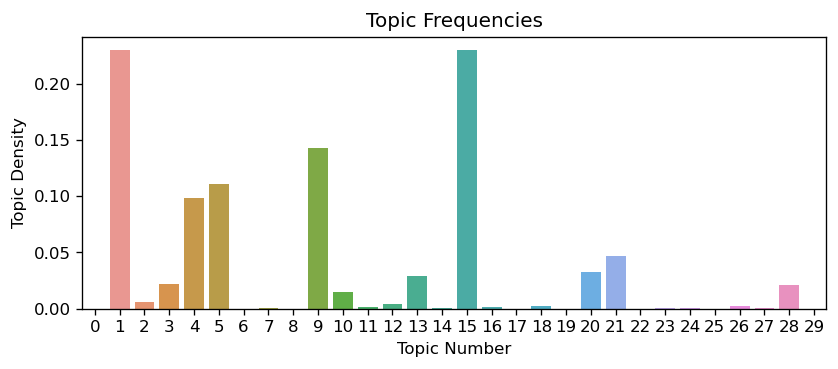

In [78]:
if perform_computation:
    fig, ax=plt.subplots(figsize=(8,3), dpi=120)
    sns.barplot(x=np.arange(30), y=np.exp(log_pi).reshape(-1), ax=ax)
    ax.set_title(f'Topic Frequencies')
    ax.set_xlabel(f'Topic Number')
    _ = ax.set_ylabel(f'Topic Density')

## 2.2 Printing The Most Frequent Words in Each Topic

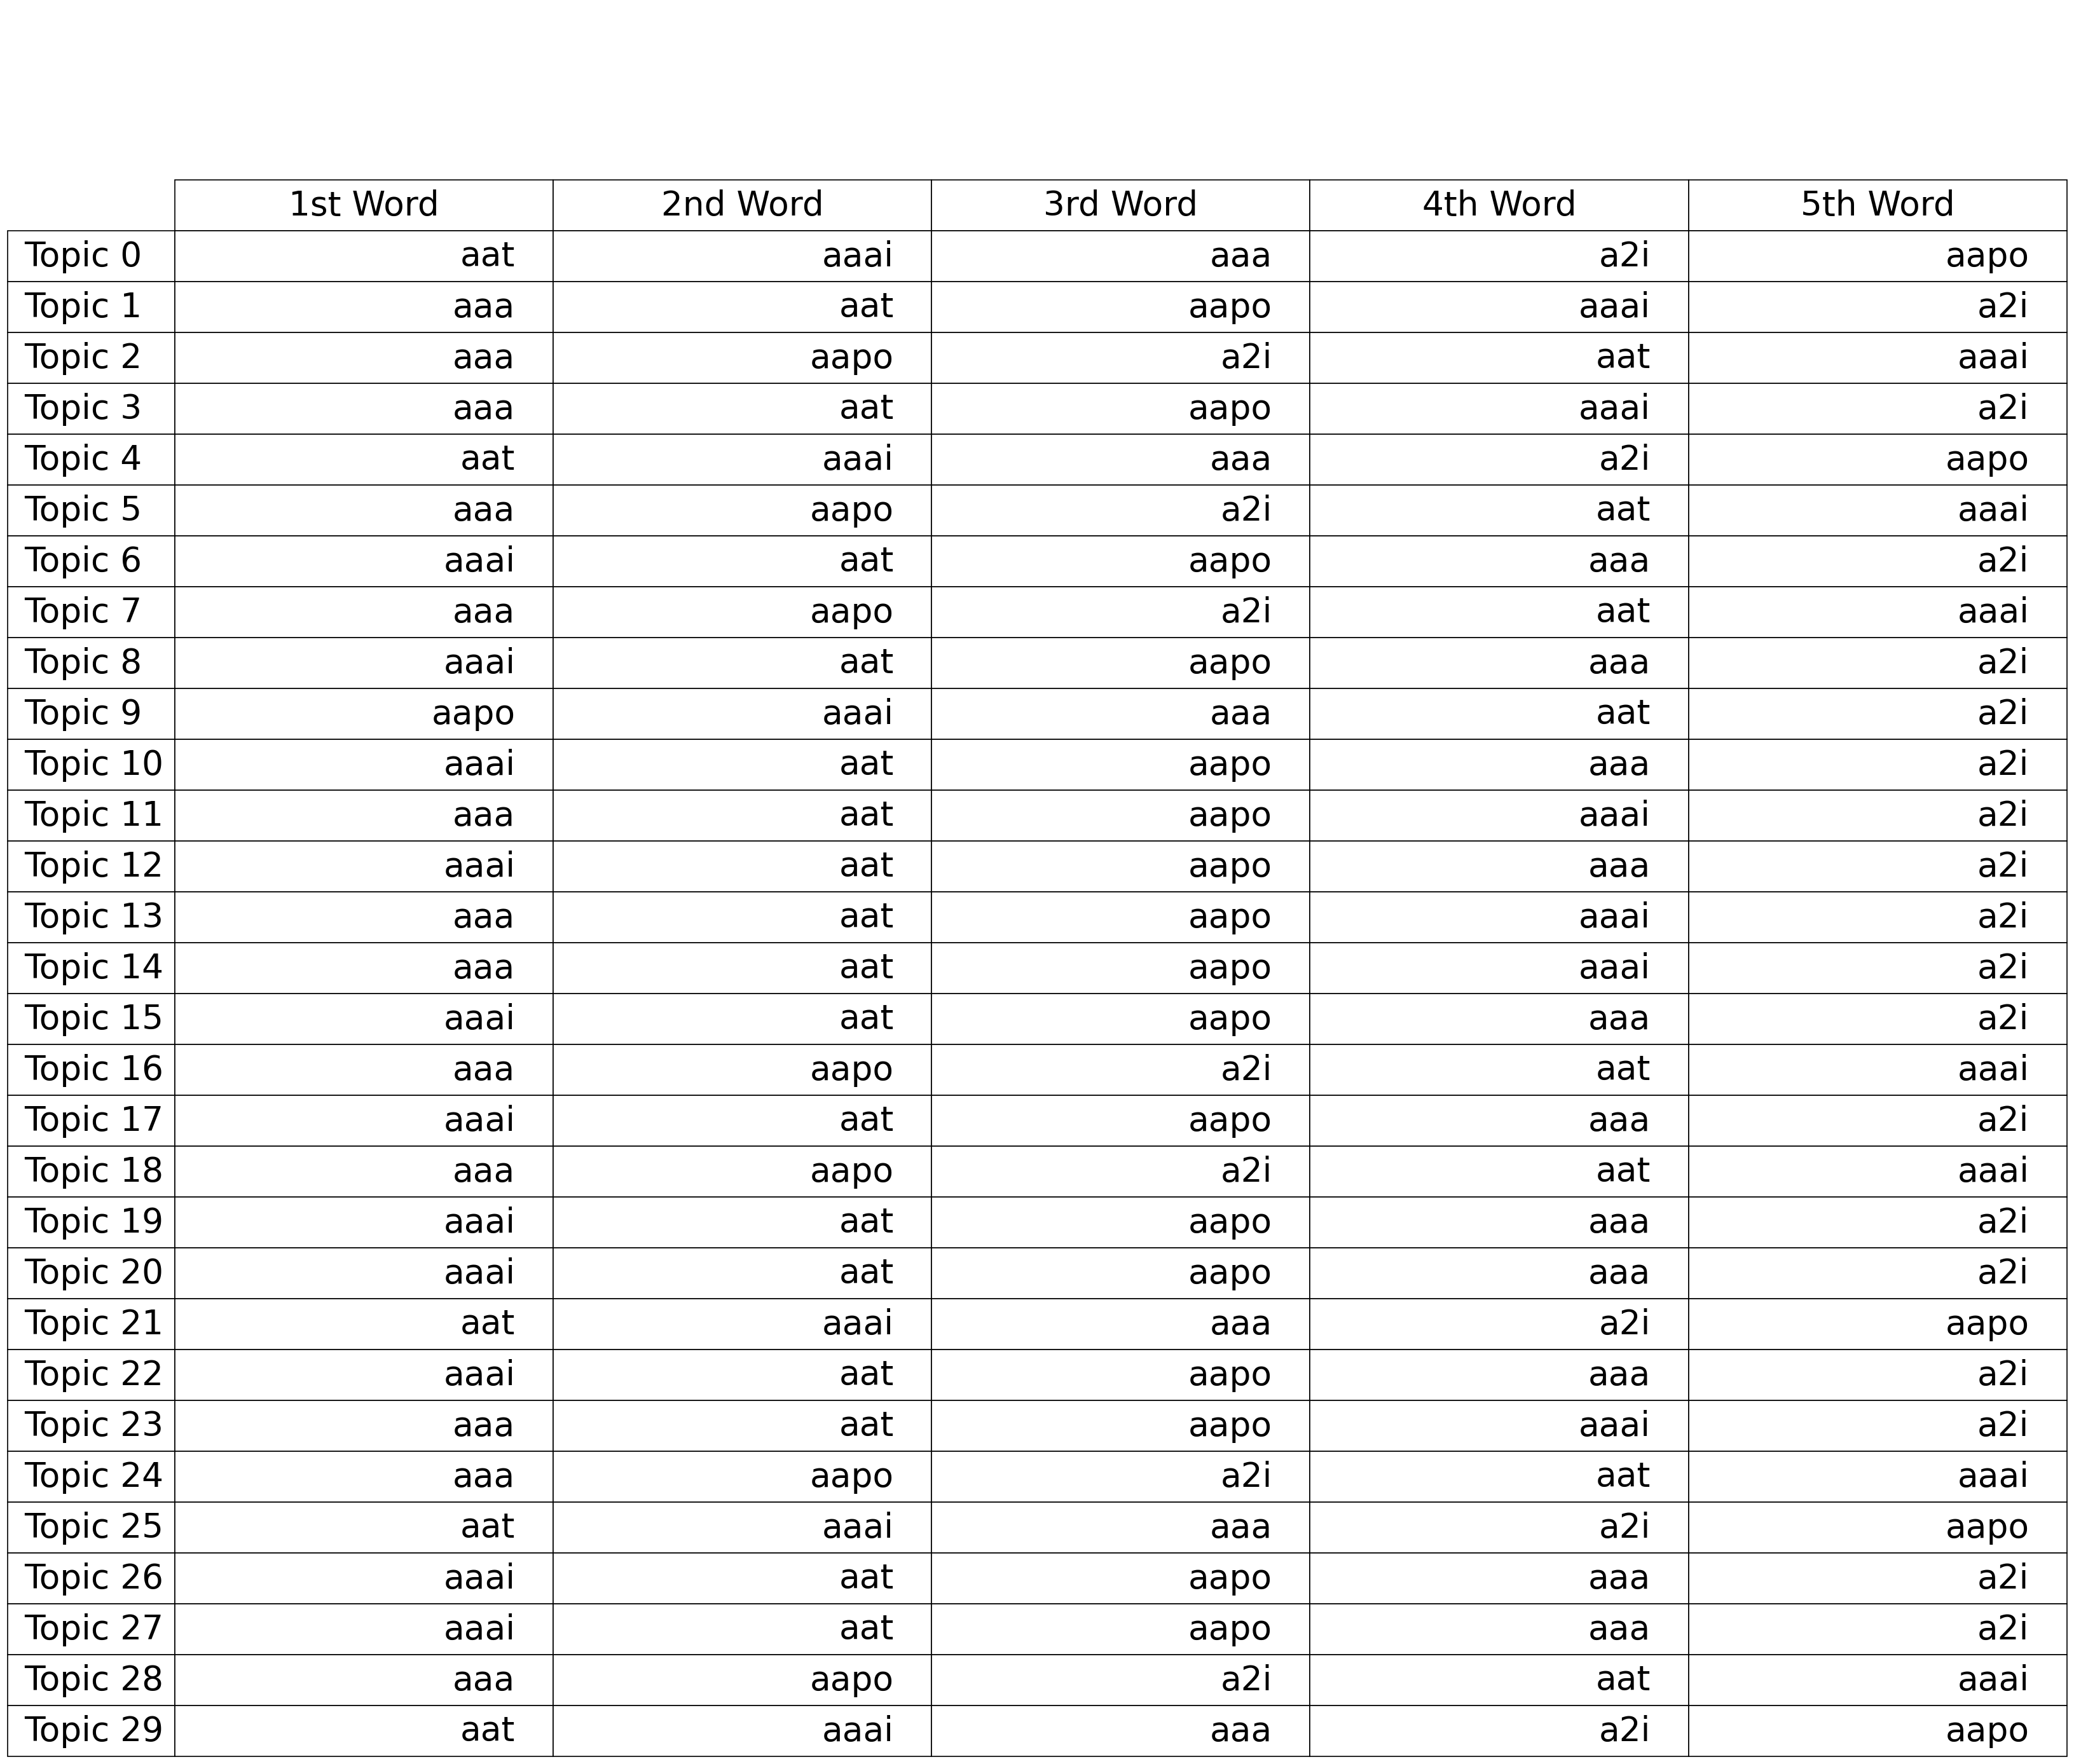

In [79]:
if perform_computation:
    top_indices = np.argsort(log_P, axis=1)[:,::-1][:, :10]
    top_words = [[words[x] for x in top_indices_row] for top_indices_row in top_indices]

    fig, ax = plt.subplots(figsize=(8,3), dpi=120)
    col_labels = ['1st Word', '2nd Word', '3rd Word'] + [f'{i}th Word' for i in range(4,11)]
    row_labels = [f'Topic {t_idx}' for t_idx in range(log_P.shape[0])]
    table_ = ax.table(top_words, colLabels=col_labels, rowLabels=row_labels)

    table_.auto_set_font_size(False)
    table_.set_fontsize(32)
    table_.scale(4, 4)

    # Removing ticks and spines enables you to get the figure only with table
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)

    fig.tight_layout()